 # eTransafe Omeprazole Heatmap

This is the use scenario that has been described in the eTox project for exploring the differences with respect to adverse events between omeprazole preclinical and clinical. In order to compute these results the following scenario is executed:
1. authenticate with the eTransafe keycloak
2. Translate the provided compound (e.g., omeprazole) to a SMILES
3. Retrieve similar compounds based on structural similarity
4. Retrieve data from the preclinical and clinical databases
5. Aggregate the data per system organ class
6. Visualize the data using a heatmap

(C) 2021 Erasmus University Medical Center, Rotterdam, The Netherlands
Author: Erik M. van Mulligen, e.vanmulligen@erasmusmc.nl

In [1]:
import sys
sys.path.append('/Users/mulligen/git/etransafe-use-scenarios')
from knowledgehub.api import KnowledgeHubAPI
import ipywidgets as w
from IPython.display import display, Javascript
from ipypublish import nb_setup
import numpy as np
import numpy.ma as ma
import seaborn as sns
import pandas
from matplotlib.colors import LogNorm, Normalize
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
api = KnowledgeHubAPI(server='TEST', client_secret='39c644b3-1f23-4d94-a71f-e0fb43ebd760')

# 1. Authentication
Use eTransafe's authentication service to get access to available services

In [3]:
from IPython.core.display_functions import clear_output

username = w.Text(value='erik.mulligen',placeholder='Knowledge Hub account', description='username:', disabled=False)
password = w.Password(value='', placeholder='Knowledge Hub password', description='password:', disabled=False)
loginBtn = w.Button(description='Login')
def on_button_clicked(_):
    if api.login(username.value, password.value) == False:
        print("Failed to login")
    else:
        print("successfully logged in")
        display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+2)'))

loginBtn.on_click(on_button_clicked)
w.VBox([username, password, loginBtn])


successfully logged in


<IPython.core.display.Javascript object>

## 2. Translate compound to SMILES using semantic services
For the entered compound name, retrieve the associated SMILES using the semantic services

In [4]:
compoundName = w.Text(value='omeprazole',placeholder='compound name', description='compound:', disabled=False)
compoundBtn = w.Button(description='Retrieve')
compoundSmile = None

def on_compound_entered(_):
    global compoundSmile
    print(f'retrieving smiles for {compoundName.value}')
    compoundSmile = api.ChemistryService().getSMILESByName(compoundName.value)
    print(f'Found SMILES {compoundSmile} for {compoundName.value}')
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+2)'))

compoundBtn.on_click(on_compound_entered) 
w.VBox([compoundName, compoundBtn])

retrieving smiles for omeprazole
Found SMILES ['COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(OC)c3C)nc2c1', 'COc1ccc2nc3n(c2c1)SCc1c(C)c(OC)c(C)c[n+]1-3', 'COc1ccc2[nH]c(S(=O)(=O)Cc3ncc(C)c(OC)c3C)nc2c1'] for omeprazole


<IPython.core.display.Javascript object>

## 3. Retrieve similar compounds

In [5]:
similar_compounds = api.SimilarityService().get(compoundSmile[0])
compoundNames = []
names = []
smiles = []
similarities = []

if similar_compounds is not None:
    for similar_compound in similar_compounds:
        names.append(similar_compound['name'])
        smiles.append(similar_compound['smiles'])
        similarities.append(similar_compound['distance'])

pd = nb_setup.setup_pandas()
df = pd.DataFrame(np.random.rand(len(names),3),columns=['NAME','SMILES','SIMILARITY'])
df.NAME = names
df.SMILES = smiles
df.SIMILARITY = similarities
df.round(3)

,NAME,SMILES,SIMILARITY
0,esomeprazole,COc1ccc2[nH]c([S@@+]([O-])Cc3ncc(C)c(OC)c3C)nc2c1,1.0000
1,omeprazole,COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(OC)c3C)nc2c1,1.0000
2,pantoprazole,COc1ccnc(C[S+]([O-])c2nc3cc(OC(F)F)ccc3[nH]2)c1OC,0.6531
3,rabeprazole,COCCCOc1ccnc(C[S+]([O-])c2nc3ccccc3[nH]2)c1C,0.6275
4,dexlansoprazole,Cc1c(OCC(F)(F)F)ccnc1C[S@@+]([O-])c1nc2ccccc2[...,0.6078
5,lansoprazole,Cc1c(OCC(F)(F)F)ccnc1C[S+]([O-])c1nc2ccccc2[nH]1,0.6078


# 4. Retrieve data from the preclinical and clinical databases

In [13]:
# filter studies on being able to have a findingCode and findingVocabulary and not having findings for dose is 0.0 (control group)
def filterStudies(studies):
    for study in studies:
        study['findings'] = [finding for finding in study['findings'] if finding['findingType'] in ['Histopathology', 'Adverse Event', 'Adverse event', 'Adverse Reactions'] and finding['findingCode'] is not None and finding['findingCode'] != 'MC:2000001' and ('dose' not in finding or finding['dose'] != 0.0)]
    return studies

def count_studies(studies):
    return len({study['id'] for study in studies})

def count_findings(studies):
    return sum([len(study['findings']) for study in studies])

def getSmiles(smiles, target):
    conversion_table = {
        'COc1ccc2nc([S@@+]([O-])Cc3ncc(C)c(OC)c3C)[nH]c2c1': 'COc1ccc2[nH]c([S@@+]([O-])Cc3ncc(C)c(OC)c3C)nc2c1',
        'COc1ccc2nc([S+]([O-])Cc3ncc(C)c(OC)c3C)[nH]c2c1': 'COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(OC)c3C)nc2c1',
    }
    for preclinical in conversion_table:
        clinical = conversion_table[preclinical]
        if target == 'clinical' and preclinical == smiles:
            return clinical
        if target == 'preclinical' and clinical == smiles:
            return preclinical
    return smiles


def convertStudies(studies):
    for study in studies:
        study['findings'][0]['compounds'][0]['standardSmiles'] = getSmiles(study['findings'][0]['compounds'][0]['standardSmiles'], 'clinical')
    return studies

studies = {}
studies['faerspa'] = filterStudies(api.Faers().getStudiesBySMILES(smiles))
print(f'{count_studies(studies["faerspa"])} FAERS studies')
api.SemanticService().getSocs(studies['faerspa'], algorithm='MEDDRAPT2MEDDRASOC')
studies['medlinepa'] = filterStudies(api.Medline().getStudiesBySMILES(smiles))
print(f'{count_studies(studies["medlinepa"])} MEDLINE studies')
api.SemanticService().getSocs(studies['medlinepa'], algorithm='MEDDRAPT2MEDDRASOC')
studies['clinicaltrialspa'] = filterStudies(api.ClinicalTrials().getStudiesBySMILES(smiles))
print(f'{count_studies(studies["clinicaltrialspa"])} CT studies')
api.SemanticService().getSocs(studies['clinicaltrialspa'], algorithm='MEDDRAPT2MEDDRASOC')
studies['dailymedpa'] = filterStudies(api.DailyMed().getStudiesBySMILES(smiles))
print(f'{count_studies(studies["dailymedpa"])} DAILYMED studies')
api.SemanticService().getSocs(studies['dailymedpa'], algorithm='MEDDRAPT2MEDDRASOC')
studies['eTOXsys'] = filterStudies(api.eToxSys().getStudiesBySMILES(smiles))
print(f'{count_studies(studies["eTOXsys"])} eTOX studies')
api.SemanticService().getSocs(studies['eTOXsys'], algorithm='MA2MEDDRASOC')

4065 FAERS studies
549 MEDLINE studies
203 CT studies
656 DAILYMED studies
38 eTOX studies


# 5. Aggregate the data per system organ class

Since the eTox data reports events with an organ. We use our own method to map it to MedDRA's system organ class to make it comparable

In [14]:
service_names = [
                    {'name': 'faerspa', 'title':'FAERS'},
                    {'name': 'medlinepa', 'title': 'MEDLINE'},
                    {'name': 'eTOXsys', 'title': 'eTOXsys'},
                    {'name': 'dailymedpa', 'title': 'DailyMed'},
                    {'name': 'clinicaltrialspa', 'title': 'ClinicalTrials'},
                ]

system = {}
all_compounds = [c.lower() for c in names]
socs = {}

def getCompoundNameBySmiles(s):
    return names[smiles.index(s)]

for service in service_names:
    source = service['name']
    if source in studies:
        for study in studies[source]:
            for finding in study['findings']:
                soc = finding['__soc']
                if soc not in socs:
                    if soc not in socs:
                        socs[soc] = set()
                    socs[soc].add(study['id'])

                    
# sort the socs per count
all_socs = {k: v for k, v in sorted(socs.items(), key=lambda item: item[1], reverse=True)}


# traverse all studies and create a matrix per source
total_count = {}

for service in service_names:
    source = service['name']
    if source in studies:
        source_study_ids = set()    
        system[source] = {
                            'data':np.zeros((len(all_socs),len(all_compounds)), dtype=int).tolist(),
                            'studies': [set() for i in range(len(all_compounds))],
                            'rows':list(all_socs.keys()),
                            'cols':all_compounds}
        # study_ids = [ [set()] * len(all_compounds) for i in range(len(all_socs)) ]
        for study in studies[source]:  
            col = system[source]['cols'].index(getCompoundNameBySmiles(study['standardSmile']))
            for finding in study['findings']:
                soc = finding['__soc']
                row = system[source]['rows'].index(soc)
                system[source]['data'][row][col] += 1
            system[source]['studies'][col].add(study['id'])
            source_study_ids.add(study['id'])
        total_count[source] = len(source_study_ids)

# 6. Visualize the data using a heatmap

Using seaborn to visualize the content of the various databases. Note that we have to think about ways to easier compare the various results.

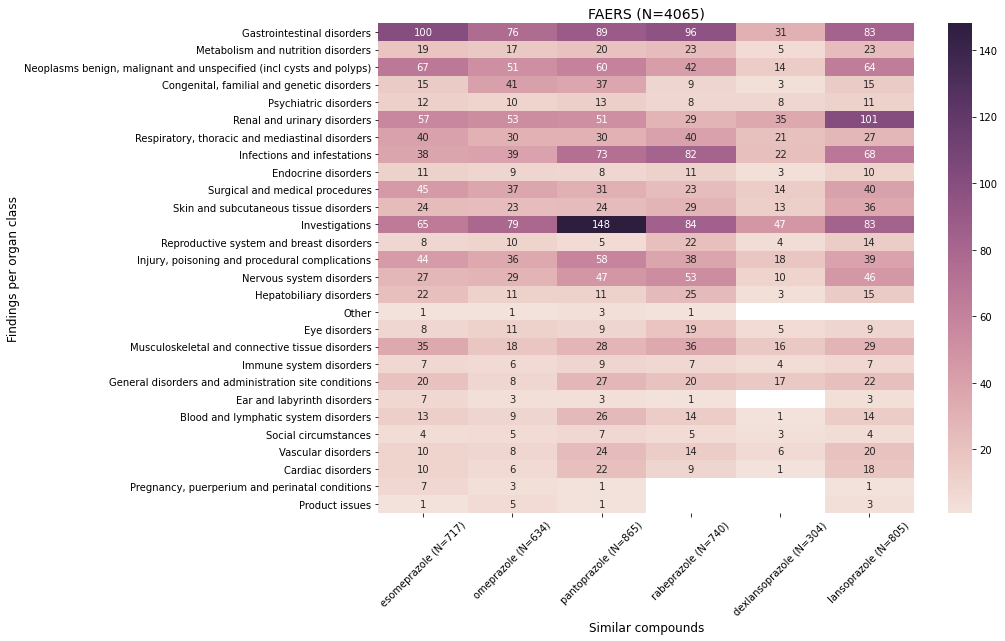

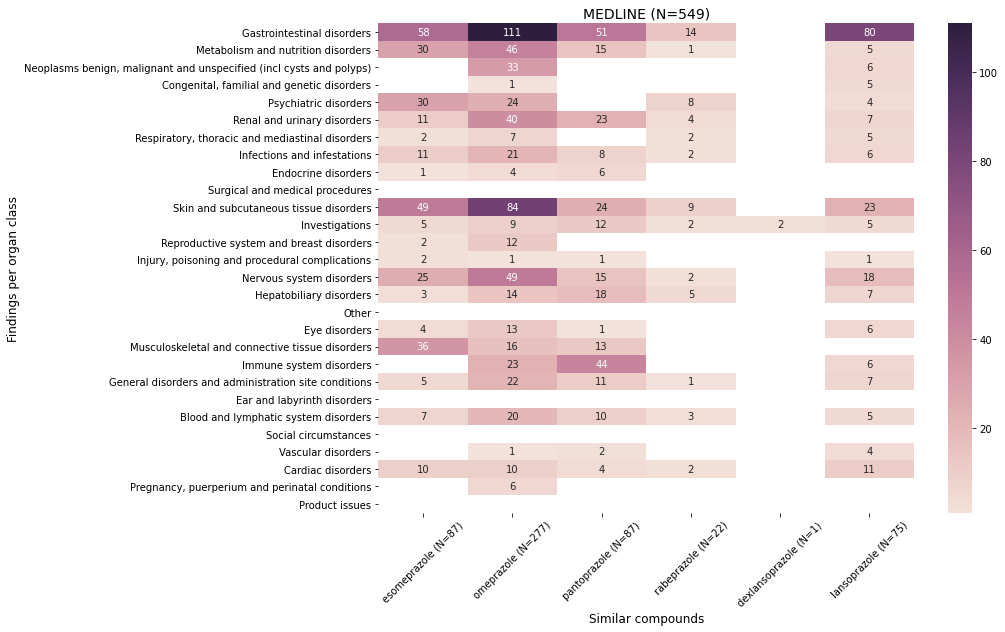

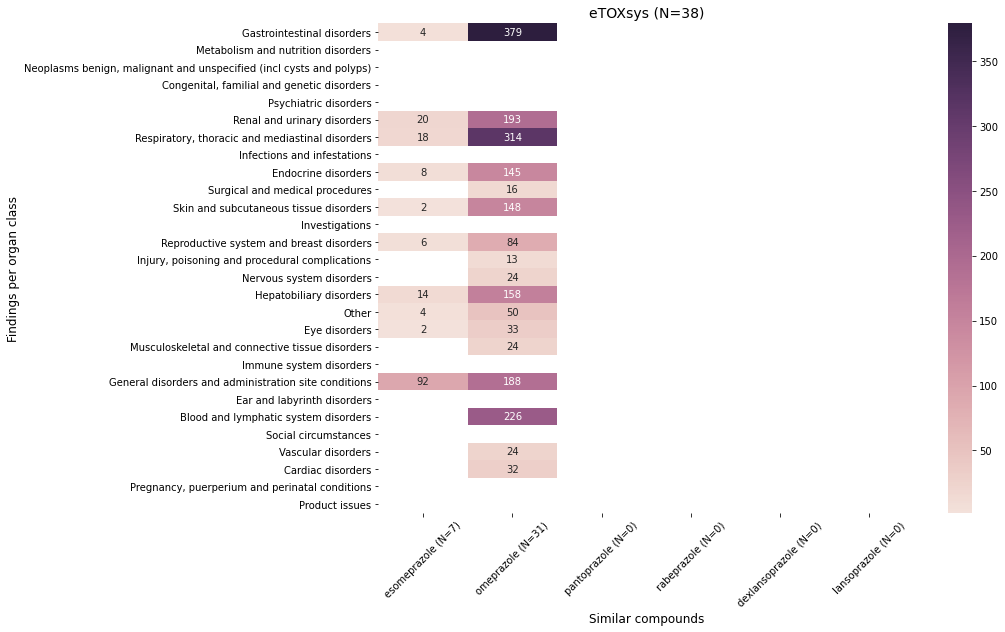

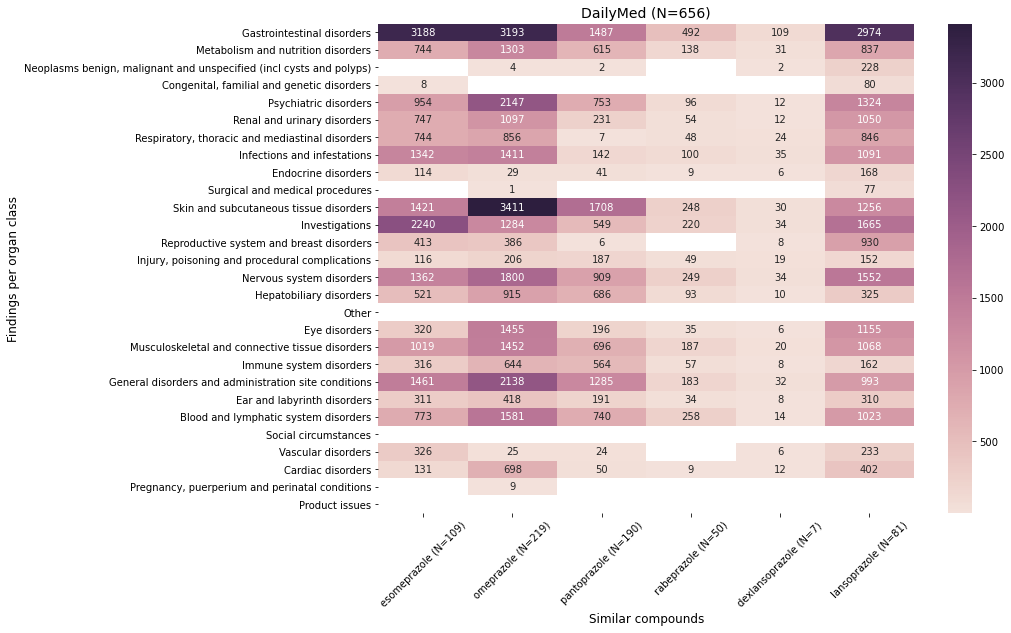

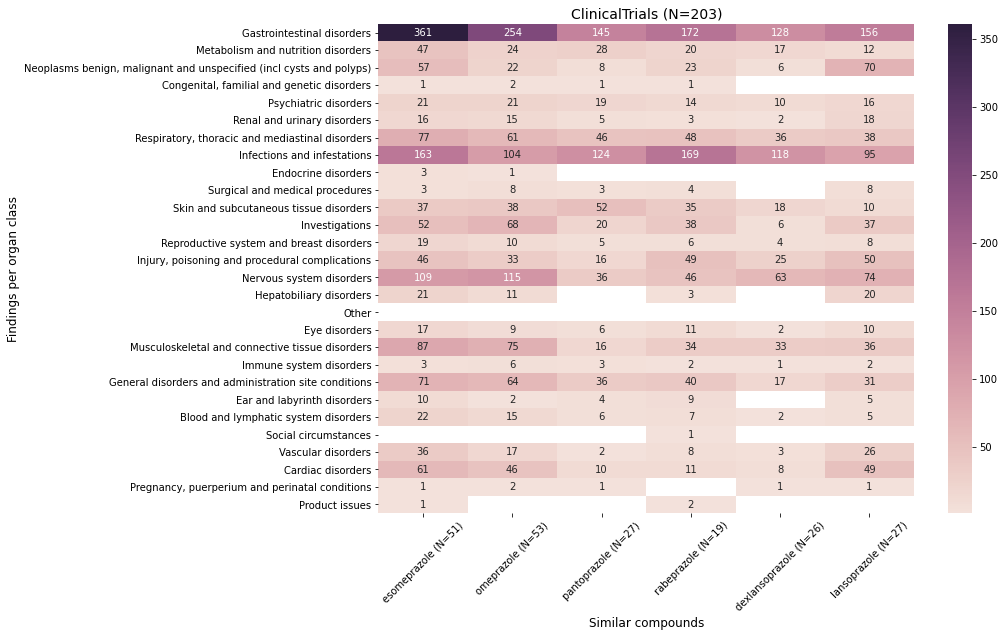

In [15]:
for source,value in system.items():
    plt.figure(figsize=(12,9))
    data = system[source]['data']
    
    # create mask
    data_mask = ma.array(np.zeros((len(all_socs.keys()), len(all_compounds))))
    for r in range(0, len(all_socs.keys())):
        for c in range(0, len(all_compounds)):
            data_mask[r][c] = 1 if data[r][c] == 0 else 0
            
    colormap = sns.cubehelix_palette(as_cmap=True, light=.9)
    
    col_count = [0] * len(all_compounds)
    col_studies = [set() for _ in range(0, len(all_compounds))]
    for row in range(len(all_socs)):
        for col in range(0, len(all_compounds)):
            col_count[col] += data[row][col]
    
    for col in range(0, len(all_compounds)):
        col_studies[col].update(system[source]['studies'][col])

            
    col_labels = [f'{all_compounds[c]} (N={len(col_studies[c])})' for c in range(0, len(all_compounds))]
        
    ax = sns.heatmap(data, mask=data_mask, xticklabels=col_labels, yticklabels=list(all_socs.keys()), annot=True, fmt=".0f", cmap=colormap) 
    ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=45)
    
    title = source
    for service_name in service_names:
        if service_name['name'] == source:
            title = f'{service_name["title"]} (N={total_count[source]})'
            break
            
    plt.title(title, fontsize = 14)
    plt.ylabel("Findings per organ class", fontsize = 12)
    plt.xlabel("Similar compounds", fontsize = 12)
    plt.show()

    print('')
    print('')